In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.interpolate import interp1d
from skspatial.objects import Line, Points
from skspatial.plotting import plot_3d

import functions as fun

params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "font.family" : "serif",
          "font.serif" : ["times new roman"],
          "figure.dpi" : 150}
plt.rcParams.update(params)

%matplotlib inline

In [2]:
def get_header(file):
    return np.fromfile(file, dtype=np.uint16, count=48)

def timestamp_from_header(header):
    left = 4*7
    right = left + 4
    radio_time = header[left:right]
    vec = np.array([2**16, 2**0, 2**48, 2**32])
    sum = np.dot(radio_time.astype(np.uint64), vec.astype(np.uint64))
    return sum/122.88e6/4

def readNovatel(novatel_directory, novatel_filename, start_time, stop_time):  ###  returns the attitude data from flightline... specified by gps timestamps  ###
    novatel_file = os.path.join(novatel_directory, novatel_filename)

    cols = ['GPSTime [HMS]', 'Date', 'Week', 'GPSTime [sec]', 'Latitude', 'Longitude', 'H-Ell', 'H-MSL', 'Undulation', 'X-ECEF', 'Y-ECEF', 'Z-ECEF', 'Pitch', 'Roll', 'Heading', 'COG']
    novatel = pd.read_csv(novatel_file, delim_whitespace=True, skiprows=18, skipfooter=3, on_bad_lines='warn', names=cols, engine='python')

    gps_start = start_time - (novatel['Week'][0]*604800)  ## choosing some arbitrary start/stop time for testing code
    gps_stop = stop_time - (novatel['Week'][0]*604800)

    flightline = novatel[(novatel['GPSTime [sec]'] >= gps_start) & (novatel['GPSTime [sec]'] <= gps_stop)]  ## truncates data to only take the desired flightline
    flightline.reset_index(inplace=True)

    return flightline

def get_time(novatel):  ###  finds sampling period from novatel data
    gpstime = novatel['GPSTime [sec]'].to_numpy()
    dt = np.diff(novatel['GPSTime [sec]'])[0]
    return gpstime, dt

def get_yaw_pitch_roll(novatel):

    yaw = (novatel['Heading'] - novatel['COG']).to_numpy()
    pitch = novatel['Pitch'].to_numpy()
    roll = novatel['Roll'].to_numpy()
    yaw[yaw<-180] += 360  ## so that phase doesnt wrap

    print(f'Mean Yaw:   {yaw.mean()}')
    print(f'Mean Pitch: {pitch.mean()}')
    print(f'Mean Roll:  {roll.mean()}')

    return yaw, pitch, roll

def get_xyz(novatel):

    x = novatel['X-ECEF'].to_numpy()
    y = novatel['Y-ECEF'].to_numpy()
    z = novatel['Z-ECEF'].to_numpy()

    return x, y, z

def interpolate_attitude(yaw, pitch, roll, time, dt, desired_dt=0.001, kind='linear'):

    oversample = int(dt/desired_dt)
    N = len(yaw)*oversample

    newtime = np.linspace(time[0], time[-1], N)

    yaw_interp = interp1d(time, yaw, kind=kind)
    pitch_interp = interp1d(time, pitch, kind=kind)
    roll_interp = interp1d(time, roll, kind=kind)

    yaw = yaw_interp(newtime)
    pitch = pitch_interp(newtime)
    roll = roll_interp(newtime)

    return yaw, pitch, roll, newtime


def interpolate_xyz(x, y, z, time, dt, desired_dt=0.001, kind='linear'):

    oversample = int(dt/desired_dt)
    N = len(x)*oversample

    newtime = np.linspace(time[0], time[-1], N)

    x_interp = interp1d(time, x, kind=kind)
    y_interp = interp1d(time, y, kind=kind)
    z_interp = interp1d(time, z, kind=kind)

    x = x_interp(newtime)
    y = y_interp(newtime)
    z = z_interp(newtime)

    return x, y, z, newtime

def fit_position(x, y, z):

    points = np.column_stack((x, y, z))
    line_fit = Line.best_fit(points)

    projection = np.zeros_like(points)

    for i in range(points.shape[0]):
        projection[i] = line_fit.project_point(points[i])

    return projection[:, 0], projection[:, 1], projection[:, 2]




In [3]:
###  Radar data for time stamp  ###

file = os.path.join(r'\\Sentinel\SNOWWI\Colorado2024\March\Radar_data\from_disk_F\save_data_nvme1n1\20240327T125534\chan2', r'receive_0000000000100000_1711558658.383798.dat')


In [4]:
# header = get_header(file)
# unix_start_time = timestamp_from_header(header) + 7200

In [5]:
# num_files = 400
# gps_to_unix = 315964800

# gps_start_time = unix_start_time - gps_to_unix
# gps_stop_time = gps_start_time + num_files/2

gps_start_time = 1395601198
gps_stop_time = 1395601258


In [6]:
novatel_directory = r'\\Sentinel\SNOWWI\Colorado2024\March\Novatel'
novatel_filename = r'gm_20240327.txt'

flightline = readNovatel(novatel_directory, novatel_filename, gps_start_time, gps_stop_time)
base_time, base_dt = get_time(flightline)

yaw, pitch, roll = get_yaw_pitch_roll(flightline)
yaw, pitch, roll, time = interpolate_attitude(yaw, pitch, roll, base_time, base_dt)

x, y, z = get_xyz(flightline)
xfit, yfit, zfit = fit_position(x, y, z)

xfit, yfit, zfit, _ = interpolate_xyz(xfit, yfit, zfit, base_time, base_dt)


dt = 0.001





Mean Yaw:   0.9077506968954939
Mean Pitch: 3.272272099013118
Mean Roll:  1.6509700039347155


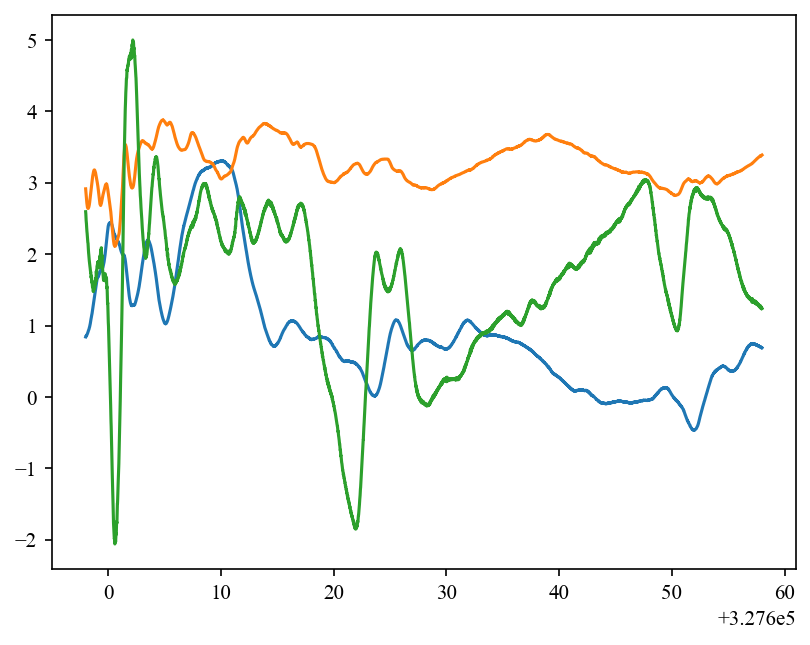

In [7]:
plt.figure()

plt.plot(time, yaw)
plt.plot(time, pitch)
plt.plot(time, roll)

plt.show()

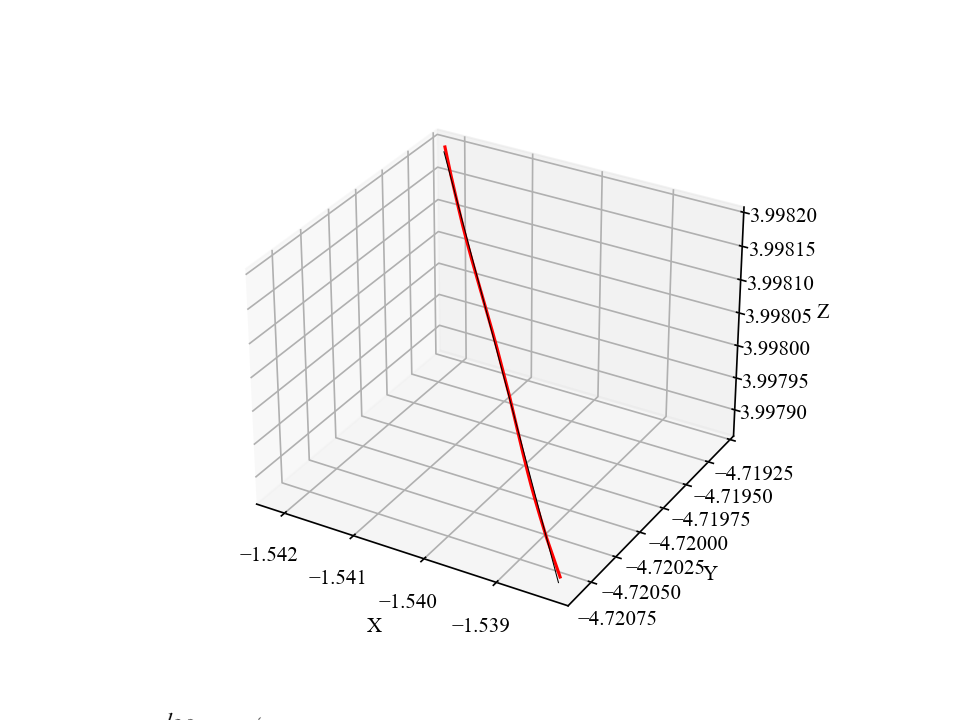

In [8]:
%matplotlib widget
ax = plt.figure().add_subplot(projection='3d')

# ax.plot(flightline['X-ECEF'], flightline['Y-ECEF'], flightline['Z-ECEF'])
# ax.plot(line_fit)
ax.plot(x, y, z, color='r')
ax.plot(xfit, yfit, zfit, color='k', linewidth=0.5)
# ax.plot(projection[:, 0], projection[:, 1], projection[:, 2])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [9]:
dx = np.diff(xfit)
dy = np.diff(yfit)
dz = np.diff(zfit)

ds = fun.rolling_avg(np.sqrt(dx**2 + dy**2 + dz**2), 1000)

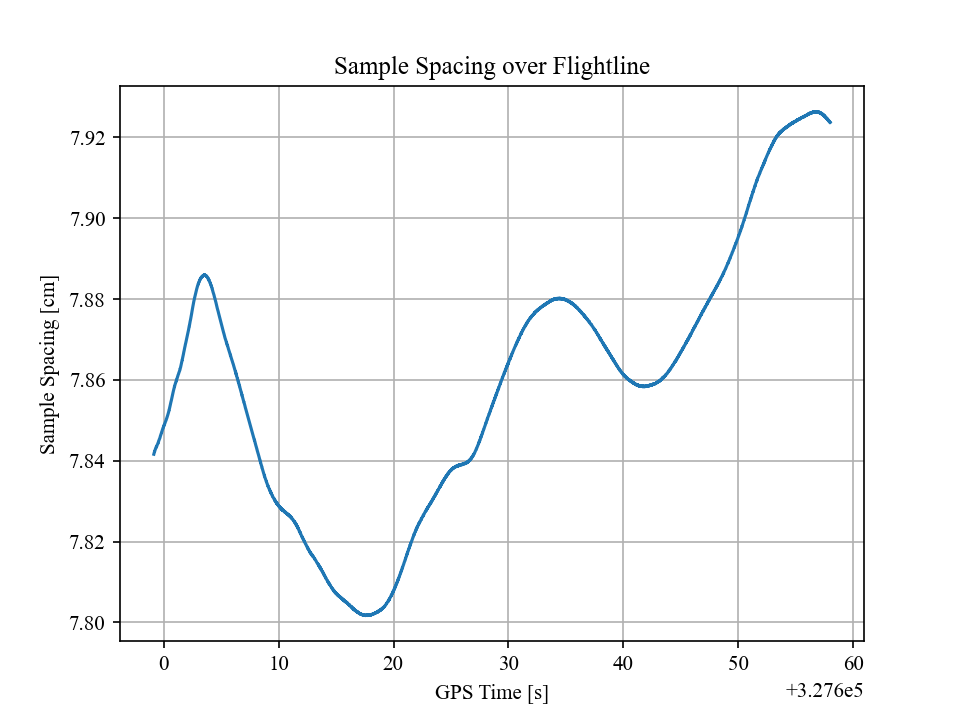

In [10]:
plt.figure()

plt.plot(time[:-1], ds*100)

plt.title('Sample Spacing over Flightline')
plt.xlabel('GPS Time [s]')
plt.ylabel('Sample Spacing [cm]')

plt.grid()
plt.show()

In [ ]:
gamma = np.linspace(0, np.radians(80), 64000) - np.radians(np.mean(roll))
psi = np.radians(np.mean(yaw))
delta = np.radians(np.mean(pitch))

squint = np.arcsin(np.sin(gamma)*np.sin(psi) + np.cos(gamma)*np.sin(delta)*np.cos(psi))


In [ ]:
plt.figure()

plt.plot(np.degrees(squint))


plt.show()